In [22]:
import torch
import numpy as np
import cv2 as cv
import os
import torch.nn as nn
import torch.nn.functional as F
import imageio
import torchvision.models as models
import torch.utils.data as Data

def ReFileName(directPath, result):

    count_num = 0 # count the files
    for file in os.listdir(directPath):
        
        if count_num % 1000 == 0: # smaller data
            print("this is " + str(count_num)+"th picture")
        # check if it is files
        if os.path.isfile(os.path.join(directPath, file)) == True:
            c= os.path.basename(file)
            name = directPath + '/' + c
            img = cv.imread(name)
     
            img = cv.resize(img, (64, 64), cv.INTER_AREA)

            GrayImage=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
            result.append([GrayImage])
        count_num += 1

# load the data in a dirctory
def individual_data_loading(name, result, label_name, addr):
    directPath = addr + name
    print("this is " + str(name))
    ReFileName(directPath, result)
    new_character = np.array(result)
    print('输入x.shape',new_character.shape)
    new_label=[label_name for i in range(len(new_character))]
    new_label=np.array(new_label)
    print('输入y.shape',new_label.shape)
    return new_character, new_label

# load all the data in different classes
def entire_data_loading(addr):
    whole_feature = []
    whole_label = []
    for i in range(29):
        new_list = []
        if i <= 25:
            data_name = chr(ord('A') + i)
        elif i == 26:
            data_name = "del" # del:26
        elif i == 27:
            data_name = "nothing" # nothing:27
        elif i == 28:
            data_name = "space" # space:28
        new_character, new_label = individual_data_loading(data_name, new_list, i, addr)
        whole_feature.append(new_character)
        whole_label.append(new_label)
    new_character = [feature for single_feature in whole_feature for feature in single_feature]
    new_label = [label for single_label in whole_label for label in single_label]
    return np.array(new_character), np.array(new_label)

traindata_address = '/Users/dumengqi/Desktop/archive/asl_alphabet_train/asl_alphabet_train/'
traindata_feature, traindata_label = entire_data_loading(traindata_address)
print(traindata_feature.shape)
print(traindata_label.shape)

# validation set
from sklearn.model_selection import train_test_split
x_traindata, x_value, y_traindata, y_value = train_test_split(traindata_feature, traindata_label, test_size=0.2, random_state=0)
print(len(y_value))
traindata_x_tensor = torch.from_numpy(x_traindata).float()
traindata_y_tensor = torch.from_numpy(y_traindata)
testdata_x_tensor = torch.from_numpy(x_value).float()
testdata_y_tensor = torch.from_numpy(y_value)

#transform to tensor
traindata_x_tensor = torch.from_numpy(traindata_feature).float()
traindata_y_tensor = torch.from_numpy(traindata_label)

In [29]:


# AlexNet_ASL net
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 7, 2, 3),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 29),
        )
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [31]:
# data loader for train
batch_num = 100
torch_dataset = Data.TensorDataset(traindata_x_tensor, traindata_y_tensor)
loader = Data.DataLoader(
    dataset=torch_dataset,        
    batch_size=batch_num,             
    shuffle=True,               
    num_workers=2,              
)

# training the model
torch.cuda.empty_cache()
model = AlexNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

epochs = 4
count_num = 0
accuracy_result = []
for epoch in range(epochs):
    for step, (batch_x, batch_y) in enumerate(loader):
        correct = 0
        images = batch_x.to(device)
        labels = batch_y.to(device)
        count_num += 1
        train = images
        outputs = model(train)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        predictions = torch.max(outputs, 1)[1].cpu()
        correct += (predictions == labels.cpu()).sum().numpy()
        if count_num == 1:
            accuracy_result.append(correct/batch_num)
        if count_num % 10 == 0:
            print(f'Epoch: {epoch+1:02d}, Iteration:{count_num:5d}, Loss:{loss.data:.4f},'+
                f'Accuracy:{100*correct/batch_num:2.3f}%')
            accuracy_result.append(correct/batch_num)

print('Finished Training')

Epoch: 01, Iteration:   10, Loss:3.3578,Accuracy:4.000%
Epoch: 01, Iteration:   20, Loss:3.3653,Accuracy:7.000%
Epoch: 01, Iteration:   30, Loss:3.3502,Accuracy:7.000%
Epoch: 01, Iteration:   40, Loss:3.3031,Accuracy:7.000%
Epoch: 01, Iteration:   50, Loss:3.2387,Accuracy:11.000%
Epoch: 01, Iteration:   60, Loss:3.1114,Accuracy:13.000%
Epoch: 01, Iteration:   70, Loss:3.0907,Accuracy:9.000%
Epoch: 01, Iteration:   80, Loss:2.7875,Accuracy:19.000%
Epoch: 01, Iteration:   90, Loss:2.7632,Accuracy:16.000%
Epoch: 01, Iteration:  100, Loss:2.5748,Accuracy:22.000%
Epoch: 01, Iteration:  110, Loss:2.4035,Accuracy:25.000%
Epoch: 01, Iteration:  120, Loss:2.2359,Accuracy:30.000%
Epoch: 01, Iteration:  130, Loss:2.0190,Accuracy:33.000%
Epoch: 01, Iteration:  140, Loss:1.9113,Accuracy:36.000%
Epoch: 01, Iteration:  150, Loss:1.9419,Accuracy:36.000%
Epoch: 01, Iteration:  160, Loss:1.7761,Accuracy:45.000%
Epoch: 01, Iteration:  170, Loss:1.5160,Accuracy:55.000%
Epoch: 01, Iteration:  180, Loss:1.3

[0.03, 0.04, 0.07, 0.07, 0.07, 0.11, 0.13, 0.09, 0.19, 0.16, 0.22, 0.25, 0.3, 0.33, 0.36, 0.36, 0.45, 0.55, 0.58, 0.53, 0.6, 0.53, 0.58, 0.57, 0.62, 0.7, 0.66, 0.65, 0.67, 0.63, 0.63, 0.8, 0.69, 0.72, 0.69, 0.69, 0.82, 0.76, 0.77, 0.65, 0.82, 0.73, 0.81, 0.75, 0.83, 0.79, 0.78, 0.86, 0.83, 0.71, 0.89, 0.82, 0.87, 0.87, 0.83, 0.95, 0.79, 0.81, 0.83, 0.82, 0.88, 0.93, 0.86, 0.86, 0.87, 0.78, 0.88, 0.87, 0.83, 0.86, 0.9, 0.9, 0.91, 0.85, 0.9, 0.91, 0.9, 0.88, 0.92, 0.87, 0.88, 0.87, 0.89, 0.91, 0.92, 0.87, 0.9, 0.88, 0.96, 0.88, 0.9, 0.86, 0.86, 0.89, 0.92, 0.85, 0.91, 0.86, 0.9, 0.92, 0.91, 0.92, 0.86, 0.89, 0.93, 0.92, 0.85, 0.99, 0.91, 0.91, 0.93, 0.92, 0.93, 0.93, 0.89, 0.91, 0.91, 0.96, 0.91, 0.94, 0.89, 0.94, 0.93, 0.91, 0.9, 0.96, 0.97, 0.9, 0.88, 0.87, 0.94, 0.92, 0.95, 0.92, 0.87, 0.89, 0.91, 0.93, 0.92, 1.0, 0.94, 0.97, 0.94, 0.94, 0.87, 0.92, 0.9, 0.95, 0.95, 0.9, 0.93, 0.92, 0.95, 0.9, 0.88, 0.92, 0.89, 0.93, 0.94, 0.97, 0.95, 0.94, 0.98, 0.96, 0.89, 0.93, 0.97, 0.95, 0.93, 0.

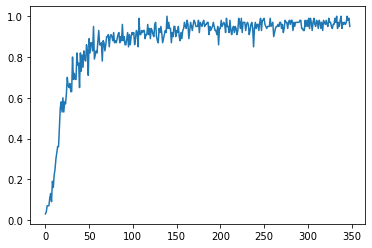

<All keys matched successfully>

In [33]:
# store the model
PATH = '/Users/dumengqi/Desktop/EE541_final_project'
torch.save(model.state_dict(), PATH)
# draw the plot
import matplotlib.pyplot as plt

print(accuracy_result)
plt.plot(accuracy_result)
plt.show()

#model = models.resnet101()
#model.conv1 = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2, bias=False)
model = AlexNet()
model.load_state_dict(torch.load('/Users/dumengqi/Desktop/EE541_final_project'))

In [36]:
# load test data
def Load_test():
    characteristic_result = []
    label_result = []
    directPath = "/Users/dumengqi/Desktop/archive/asl_alphabet_test/asl_alphabet_test"
    for file in os.listdir(directPath):
        if os.path.isfile(os.path.join(directPath, file)) == True:
            c= os.path.basename(file)
            name = directPath + '/' + c
            img = cv.imread(name)
            print("loading..." + c)
          #  img=np.transpose(img,(2,0,1))
          #  Gray
            img = cv.resize(img, (64, 64), cv.INTER_AREA)
            GrayImage=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
            characteristic_result.append([GrayImage])
          # without Gray
          #  img=np.transpose(img,(2,0,1))
          #  characteristic_result.append(img)
            label = c.split('_')[0]
            if len(label) == 1:
                label_result.append(ord(label[0]) - ord('A'))
            elif label == "del":
                label_result.append(26)
            elif label == "nothing":
                label_result.append(27)
            elif label == "space":
                label_result.append(28)
    return np.array(characteristic_result), np.array(label_result)

# transform data to tensor
from numpy.core.fromnumeric import shape
testdata_feature, testdata_label = Load_test()
print(testdata_feature.shape)
print(testdata_label.shape)
testdata_x_tensor = torch.from_numpy(testdata_feature).float()
testdata_y_tensor = torch.from_numpy(testdata_label)

# data loader for test set
batch_num = 100
torch_dataset = Data.TensorDataset(testdata_x_tensor, testdata_y_tensor)
test_loader = Data.DataLoader(
    dataset=torch_dataset,          # data
    batch_size=batch_num,               # the batch size
    shuffle=True,               # whether we shuffle the data
    num_workers=2,              # multiprocess read data
)

# test evaluaation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for step, (batch_x, batch_y) in enumerate(test_loader):
        model.eval()
        images = batch_x.to(device)
        labels = batch_y.to(device)
        test = images
        outputs = model(test)    
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += len(batch_x)
    labels = labels.cpu()
    predicted = predicted.cpu()
    # print("the accuracy value is " + str(accuracy_score(labels, predicted)))
    # print("the precision value is " + str(precision_score(labels, predicted, average='micro')))
    # print("the recall value is " + str(recall_score(labels, predicted, average='micro')))
    # print("the f1_score value is " + str(f1_score(labels, predicted, average='micro')))
    accuracy = correct * 100 / total


    print(f'Accuracy:{accuracy :.3f}%')

loading...F_test.jpg
loading...G_test.jpg
loading...L_test.jpg
loading...M_test.jpg
loading...R_test.jpg
loading...S_test.jpg
loading...X_test.jpg
loading...Y_test.jpg
loading...U_test.jpg
loading...T_test.jpg
loading...A_test.jpg
loading...K_test.jpg
loading...J_test.jpg
loading...Z_test.jpg
loading...nothing_test.jpg
loading...Q_test.jpg
loading...P_test.jpg
loading...space_test.jpg
loading...O_test.jpg
loading...N_test.jpg
loading...E_test.jpg
loading...D_test.jpg
loading...H_test.jpg
loading...I_test.jpg
loading...B_test.jpg
loading...C_test.jpg
loading...V_test.jpg
loading...W_test.jpg
(28, 1, 64, 64)
(28,)
Accuracy:100.000%
